In [6]:
import glob, sys, os
sys.path.append('..')
import output as out
import plot_helper as plt_hp
import pandas as pd
import numpy as np
from itertools import product
from effects_of_finetuning import SERVER_PROJECT_PATH

In [7]:
model_names = ['vit_small_patch16_384', 'vit_small_patch16_224', 'vit_small_patch32_224']
base_dataset = 'imagenet21k'
finetune_datasets = ['imagenet', 'cifar10', 'cifar100', 'oxford-iiit-pets']

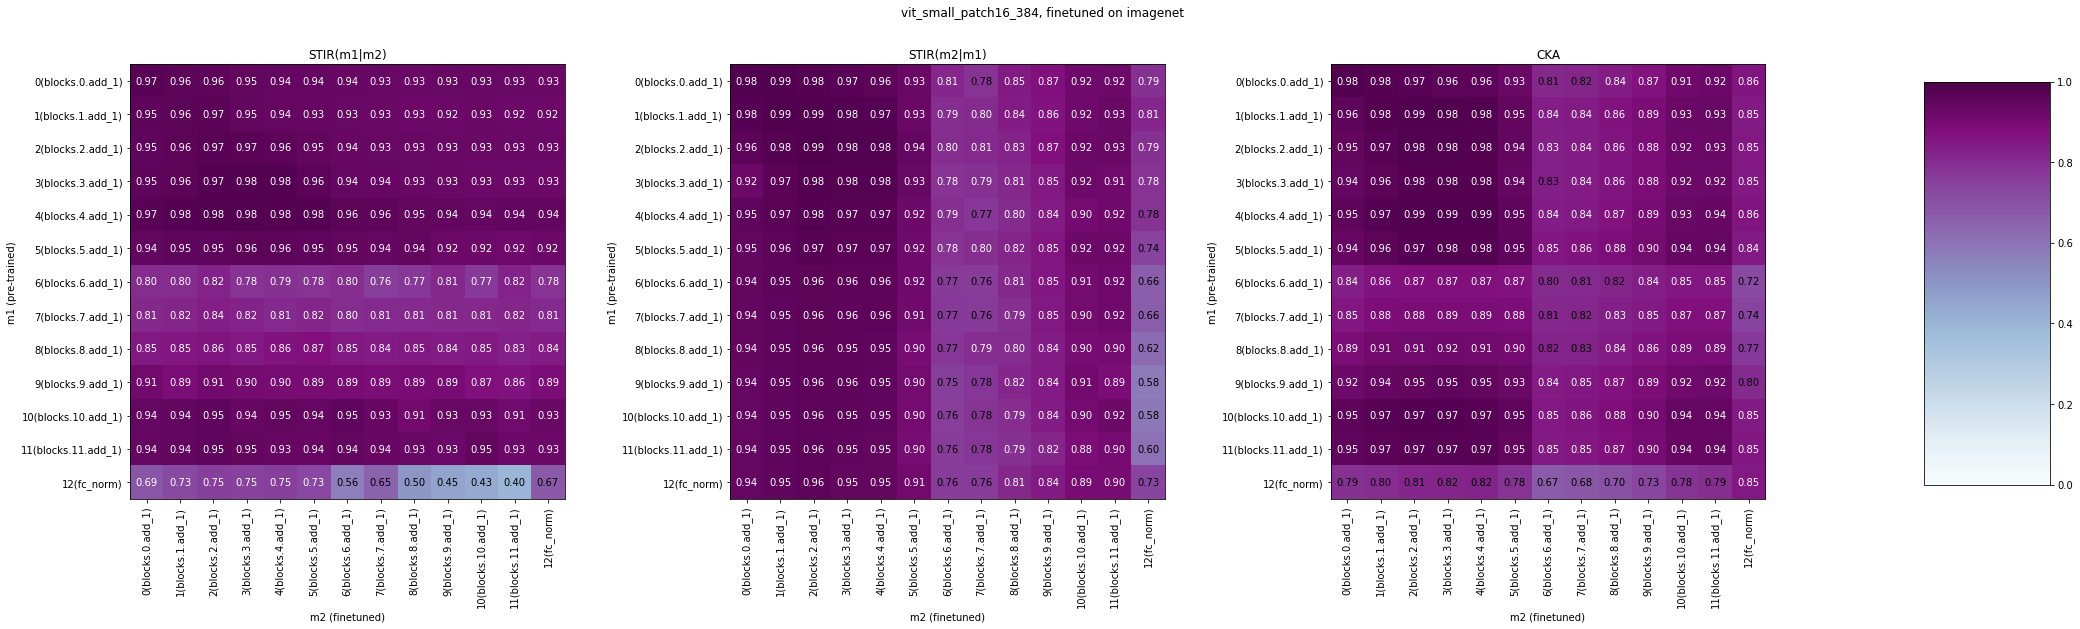

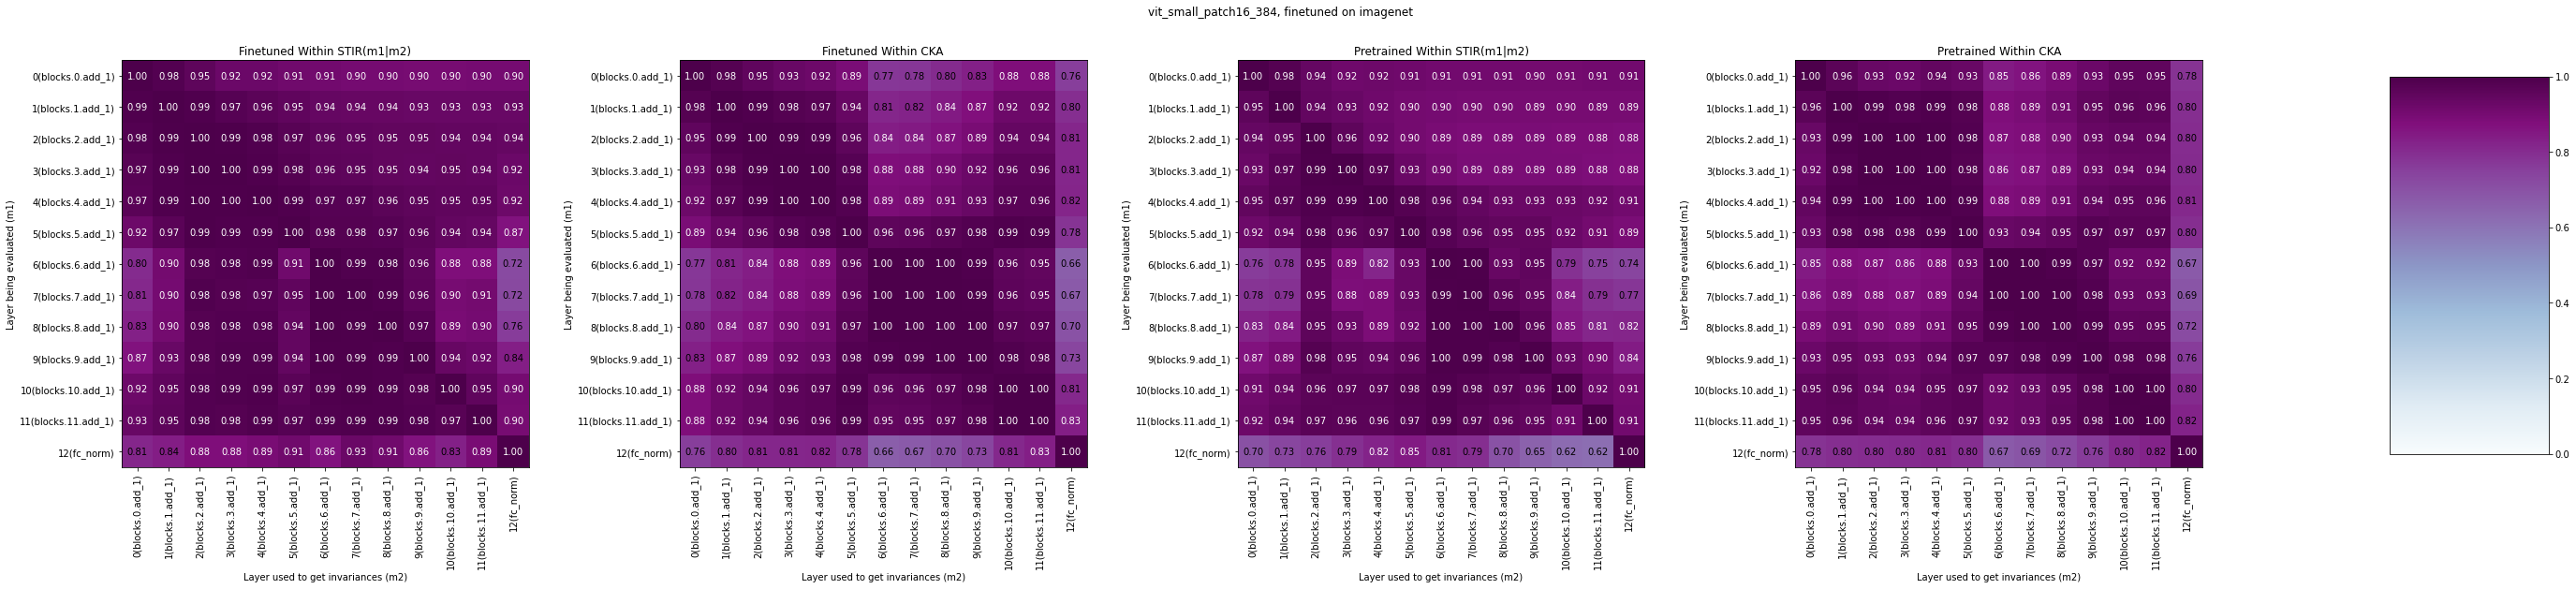

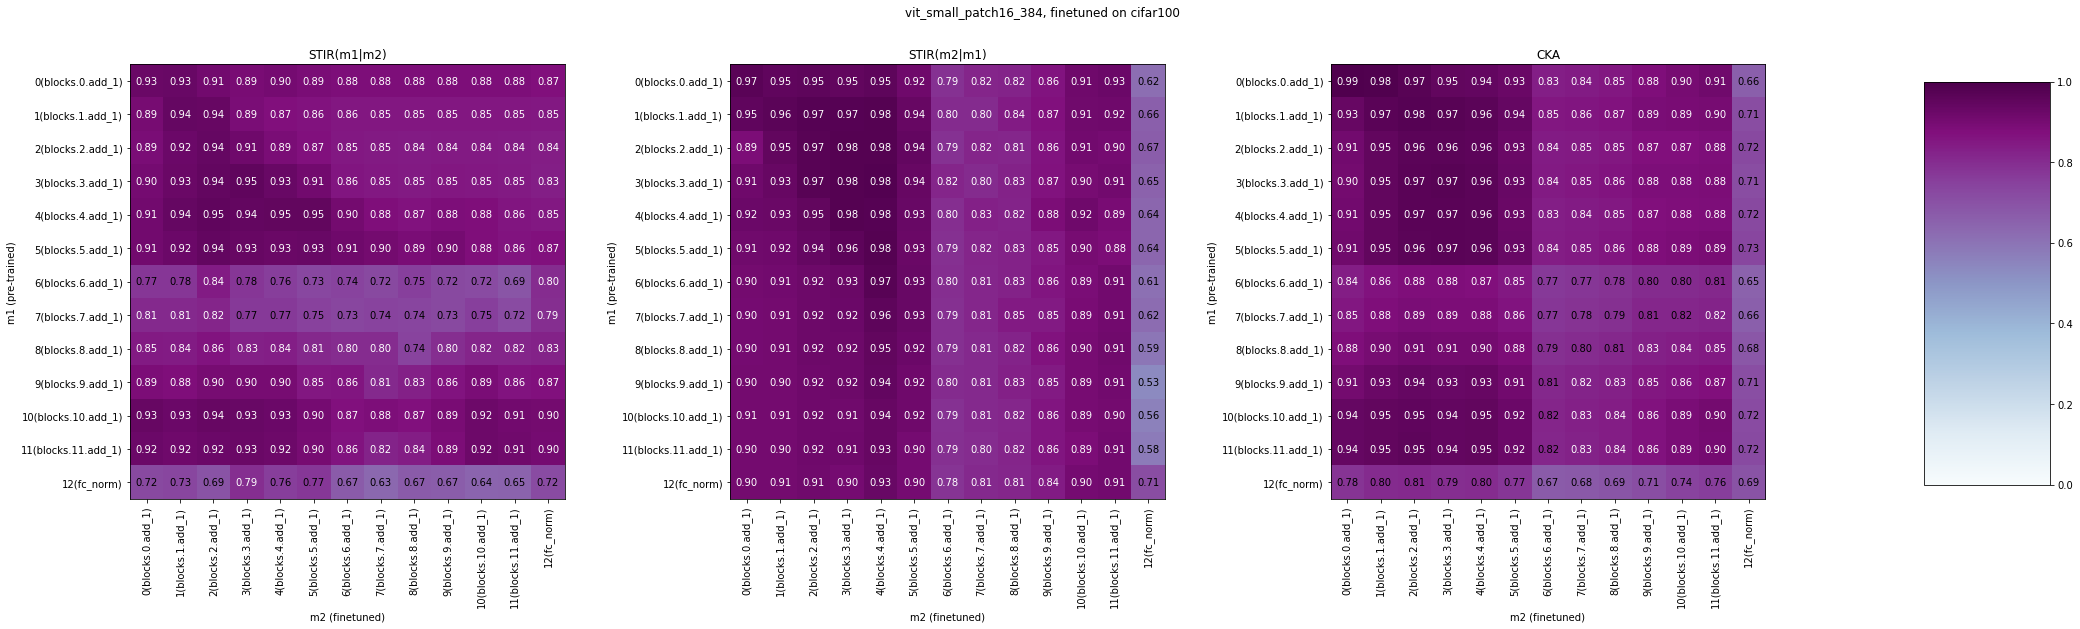

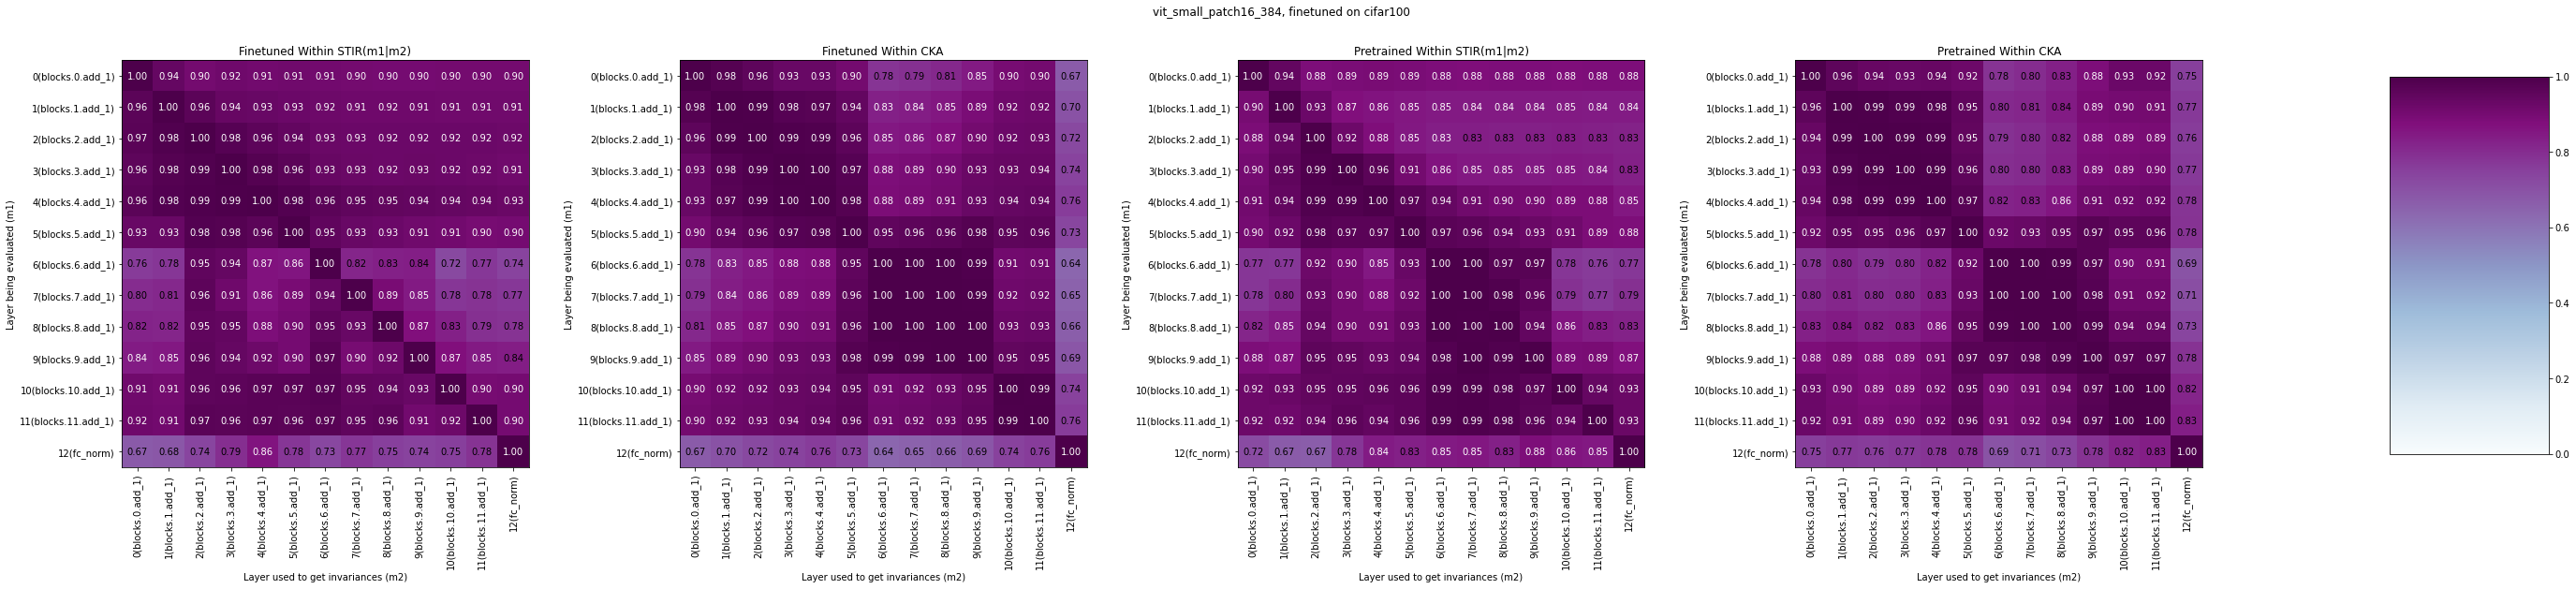

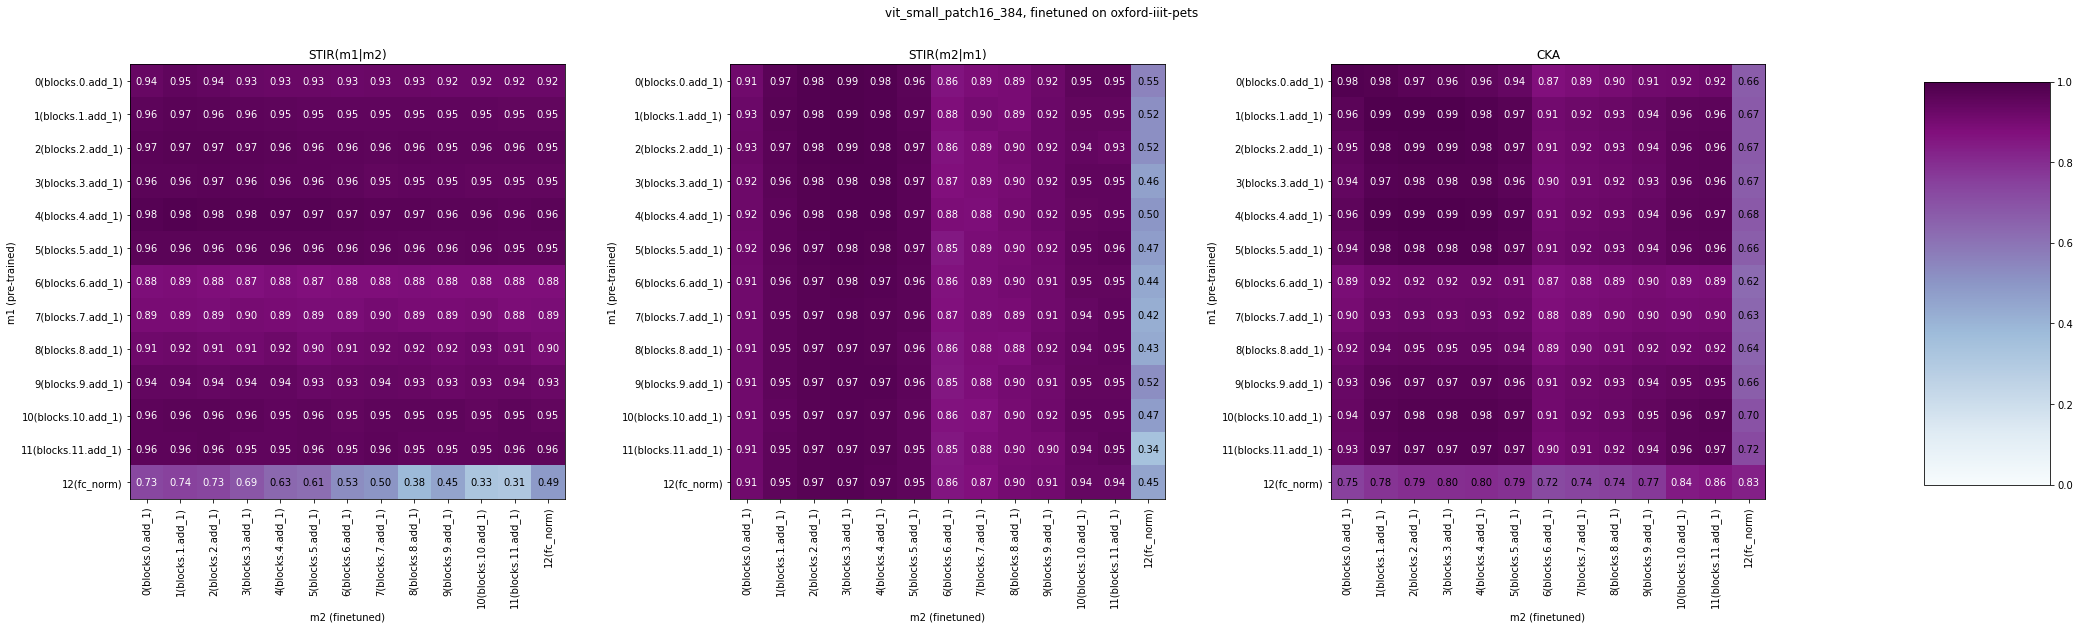

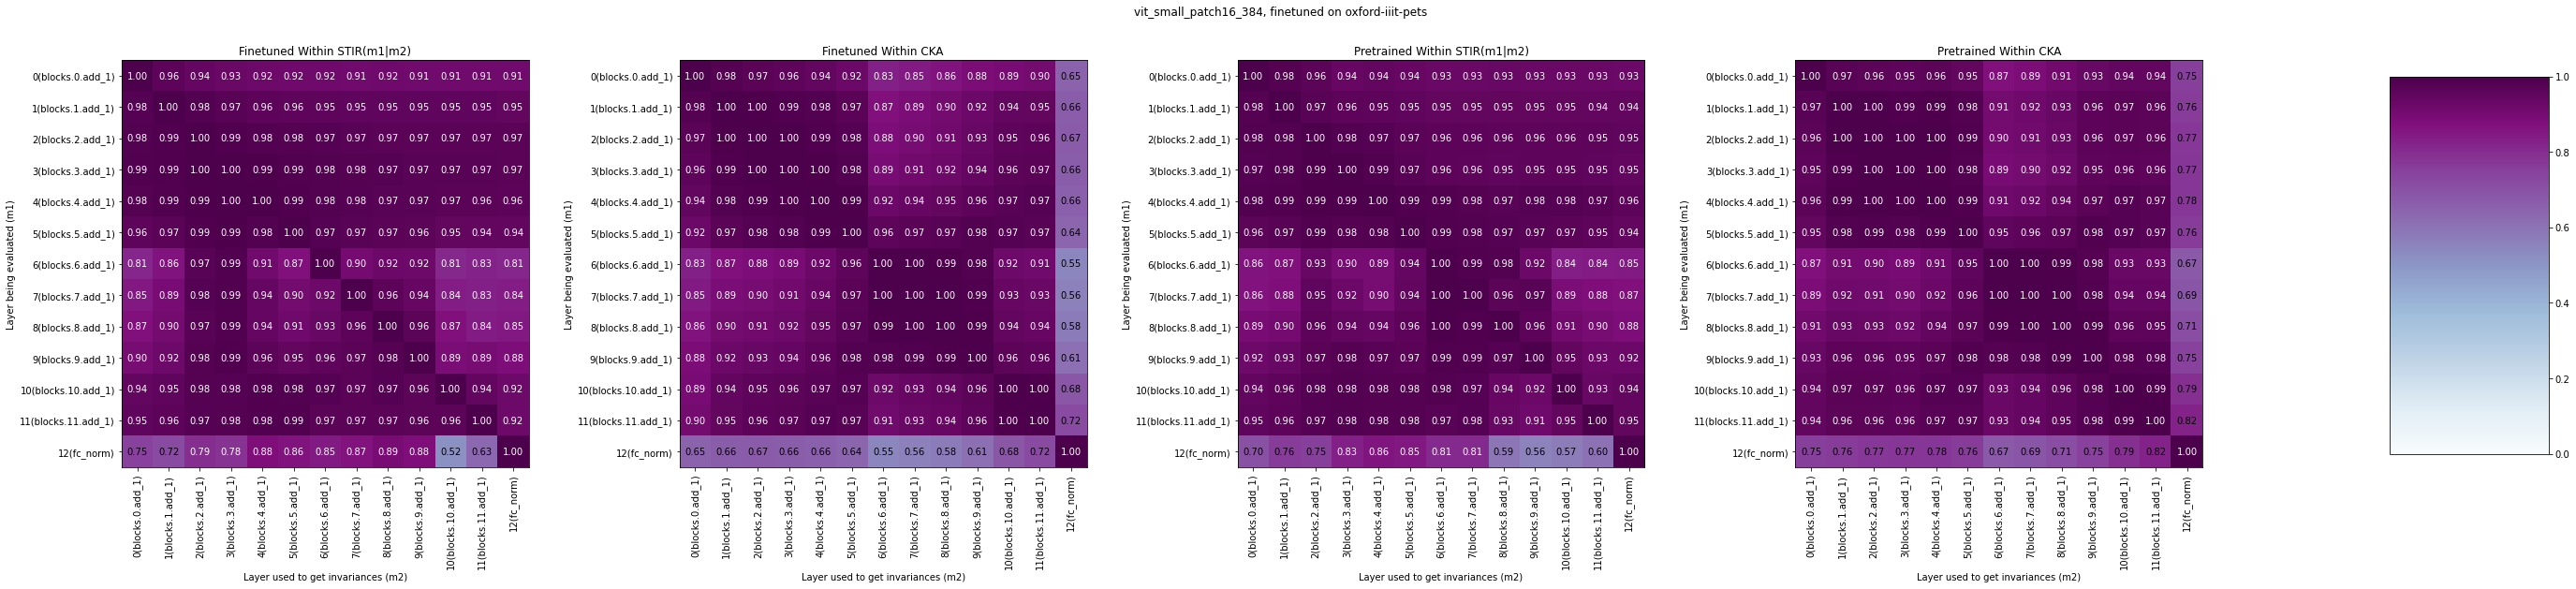

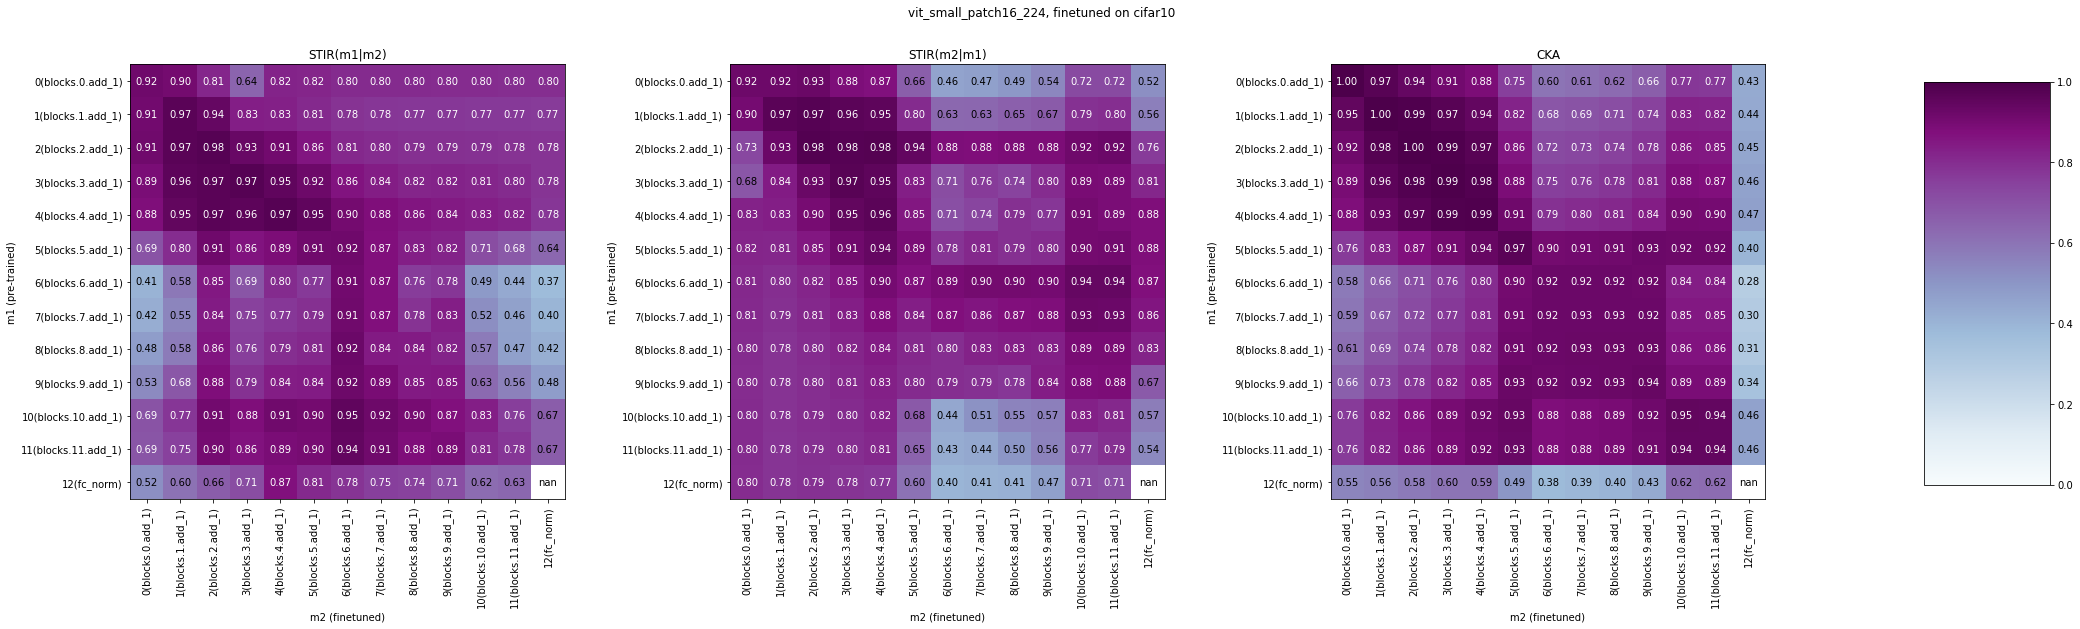

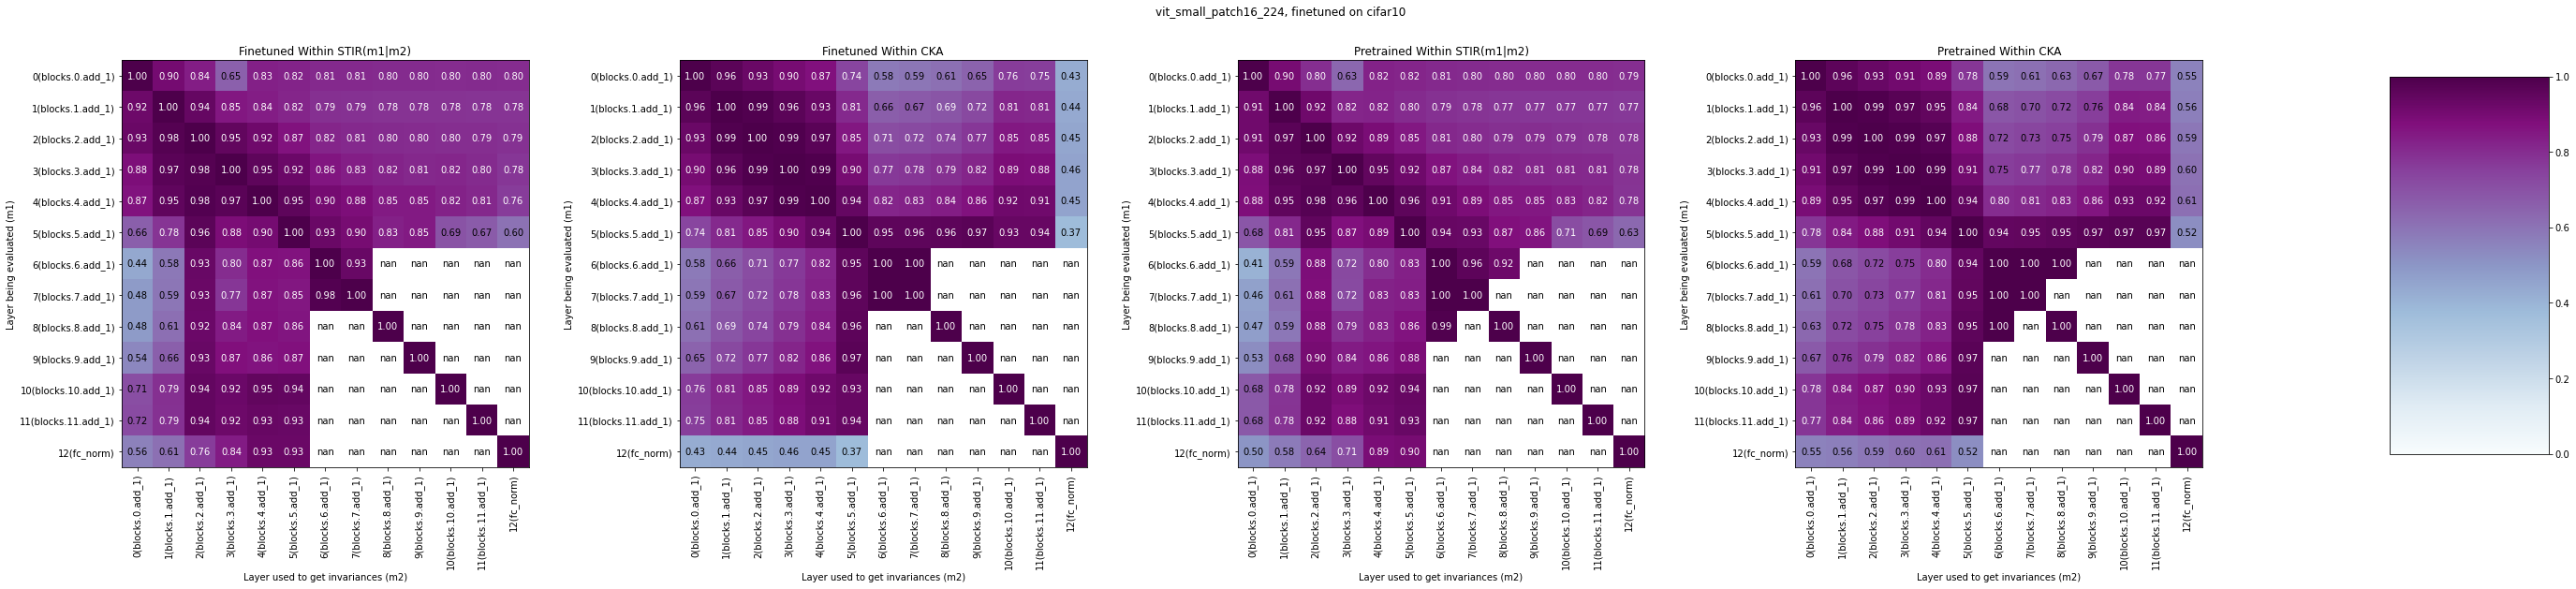

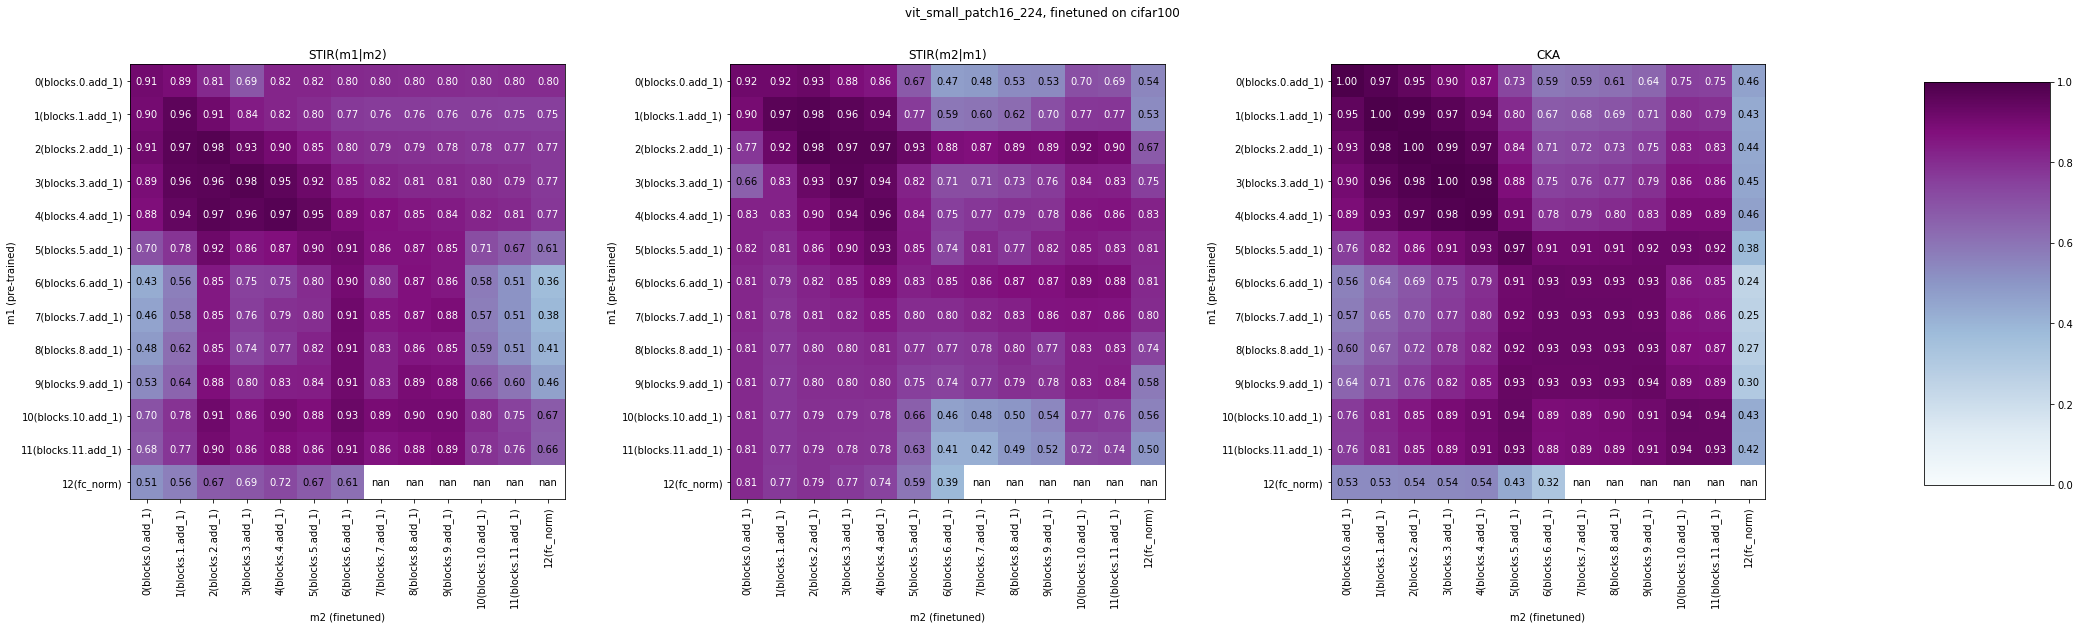

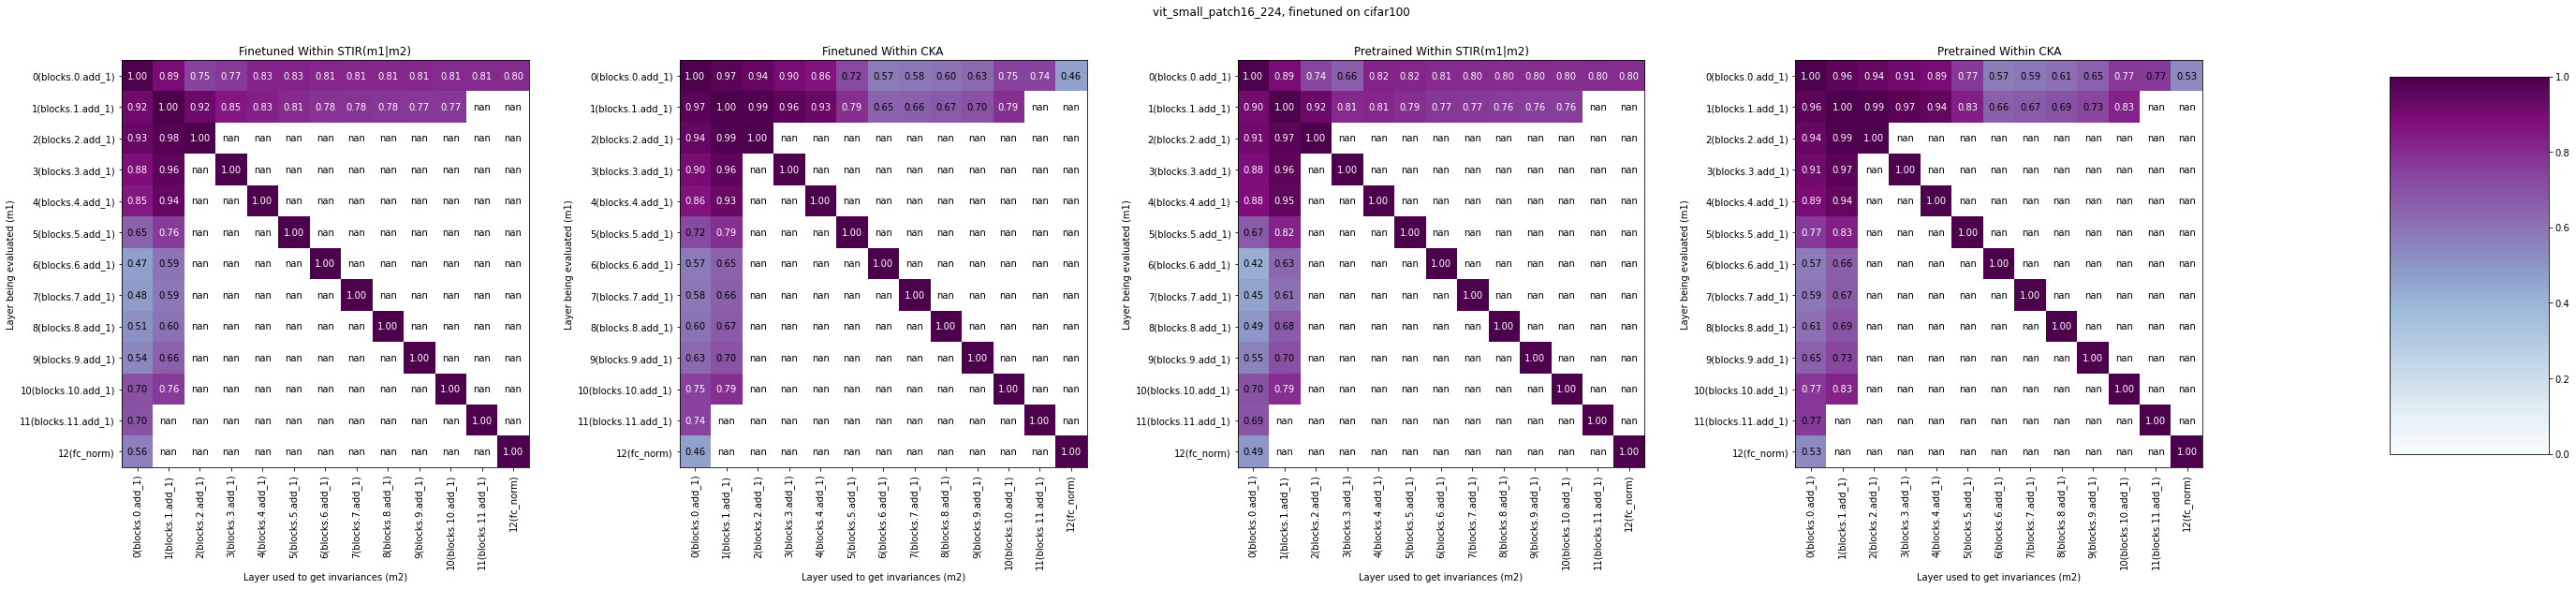

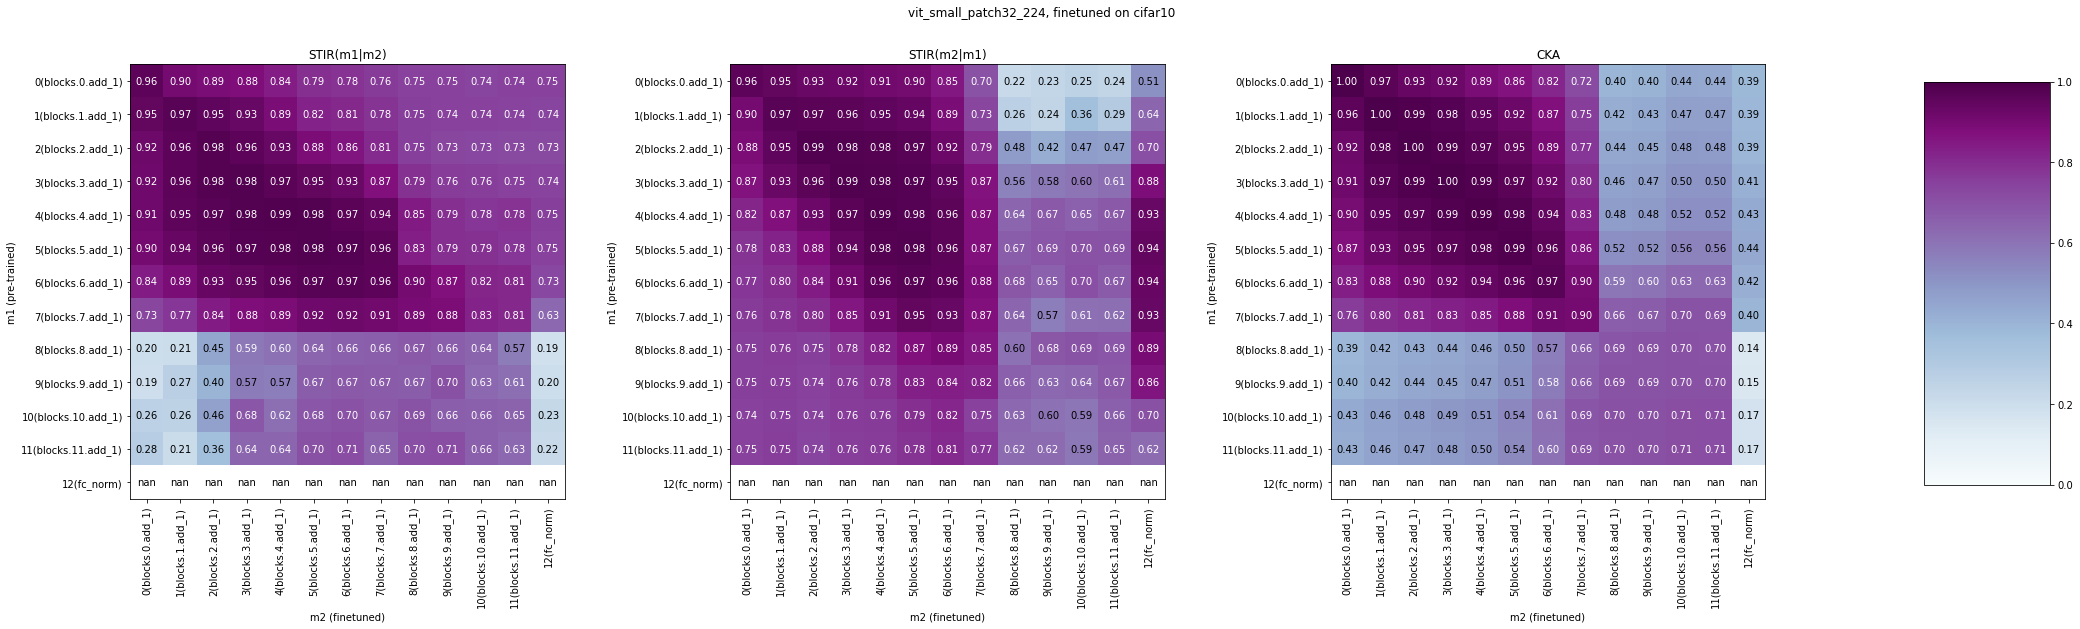

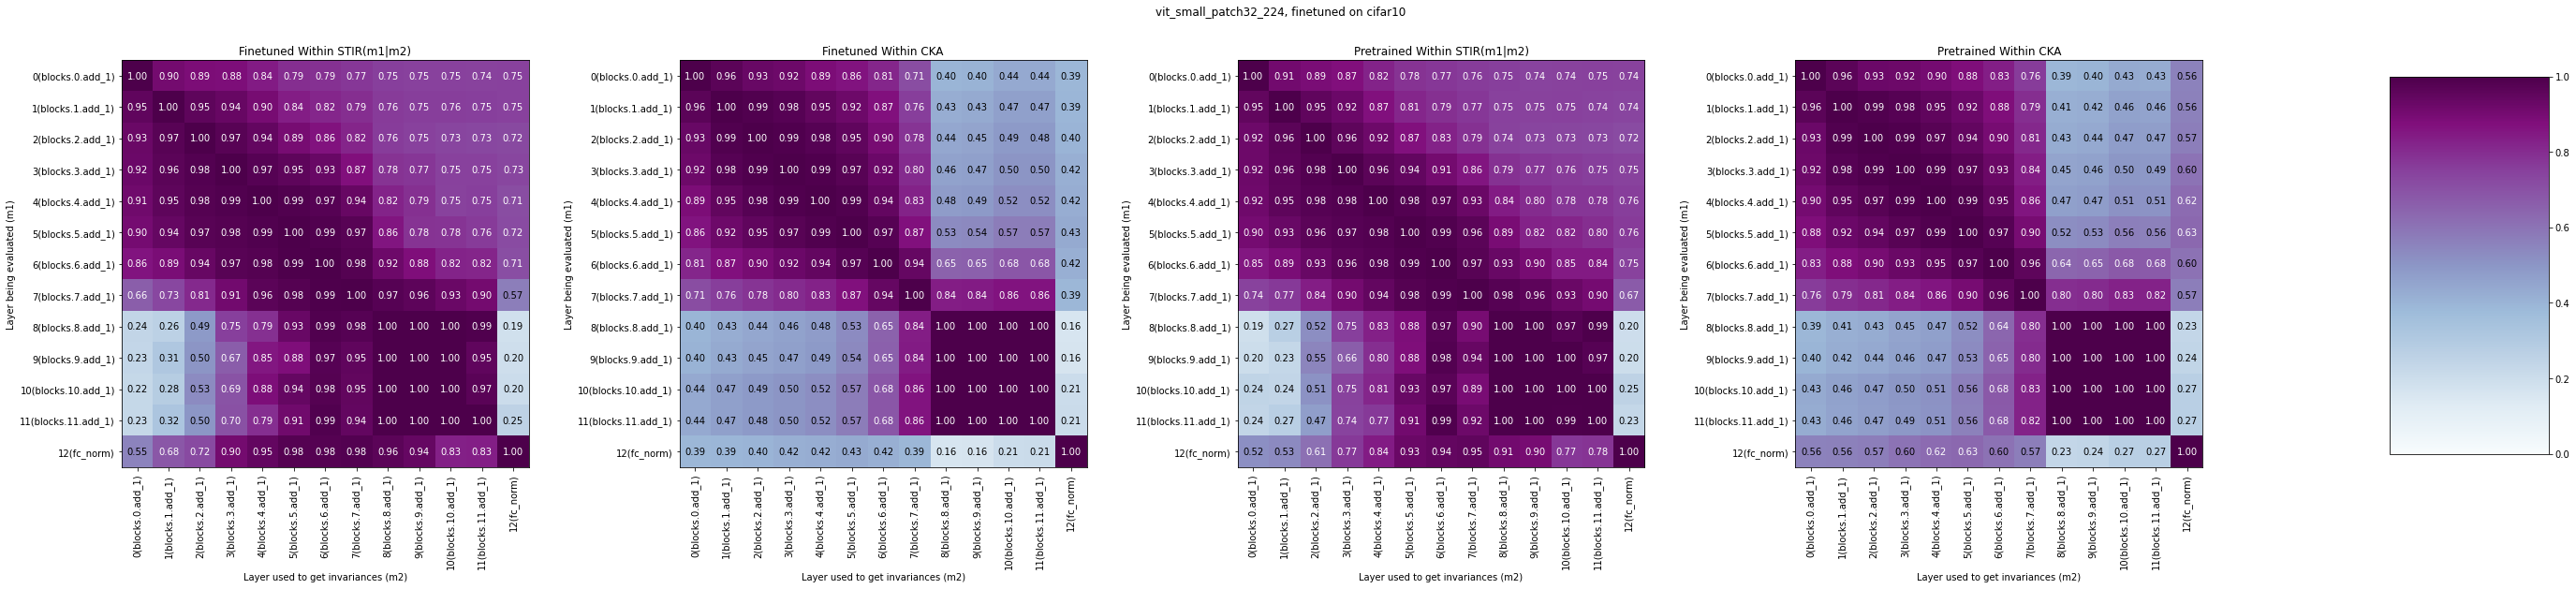

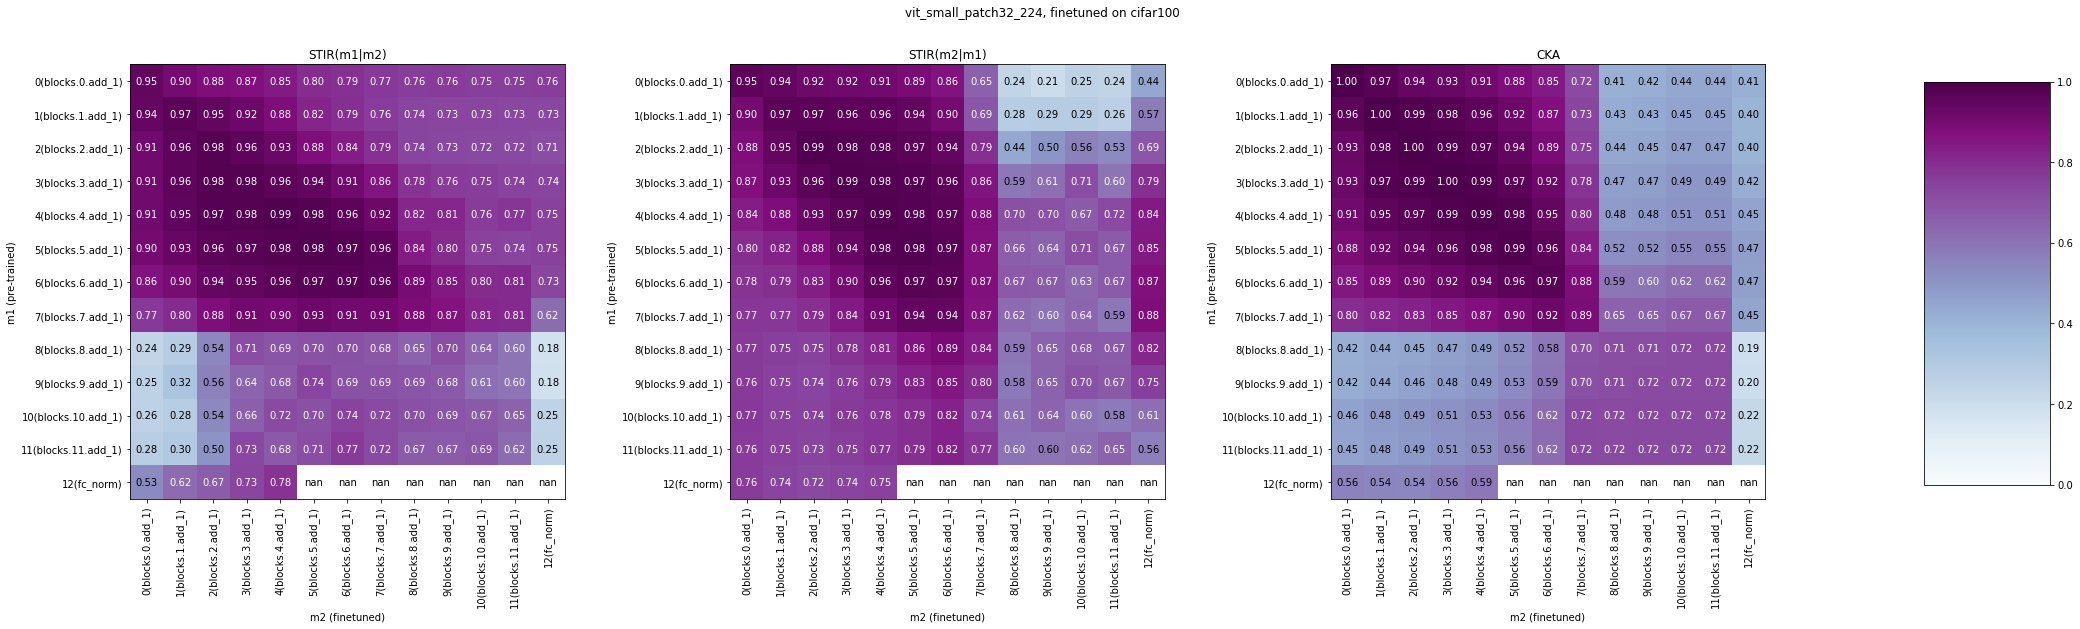

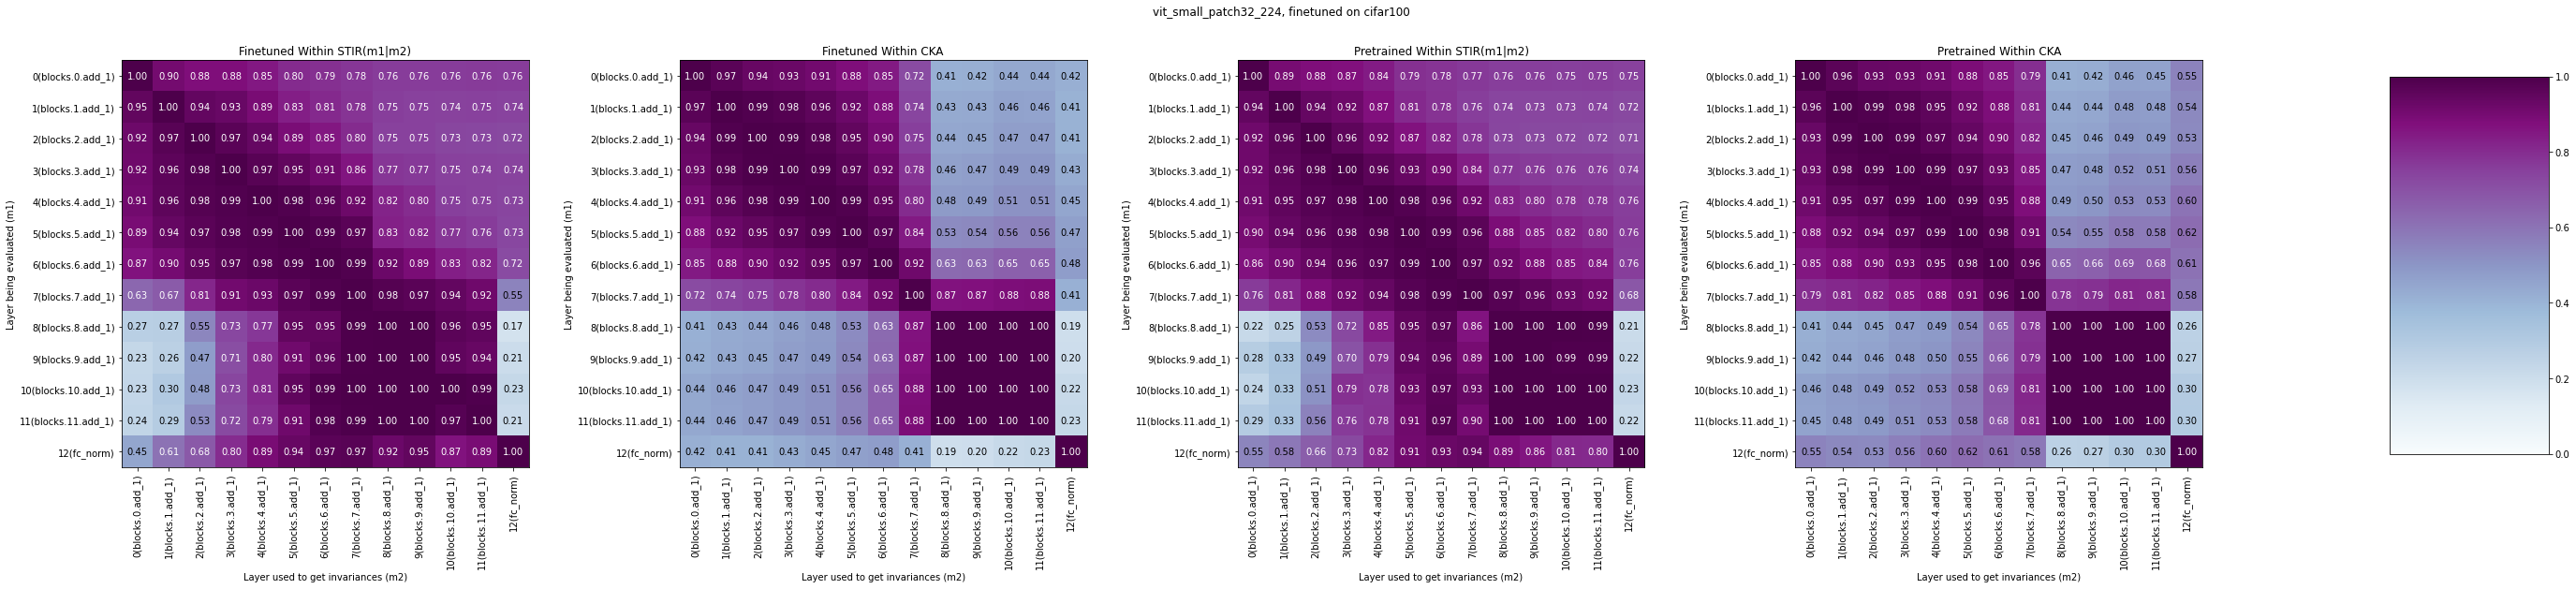

In [8]:
plt_str = '<<TableOfContents()>>\n\n= Cross Layer Comparison =\n\n'
for model_name in model_names:
    plt_str += f'== {model_name} ==\n\n'
    for ft_ds in finetune_datasets:
        results_file = f'./results/{model_name}_eval_{ft_ds}-base_'\
                       f'{base_dataset}-finetune_{ft_ds}.txt'
        within_model_ft = f'./results/{model_name}_eval_{ft_ds}-base_'\
                          f'{base_dataset}-{ft_ds}-within-model-finetuned.txt'
        within_model_base = f'./results/{model_name}_eval_{ft_ds}-base_'\
                            f'{base_dataset}-{ft_ds}-within-model-base.txt'
        if os.path.exists(results_file):
            plt_str += f'=== Pre-trained on {base_dataset}, finetuned on {ft_ds}, eval on {ft_ds} ===\n\n'
            df = pd.read_csv(results_file, header=None, sep=',',
                             names=['Base(m1)', 'Finetuned(m2)', 'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'])
            layers = df['Finetuned(m2)'].unique()
            df.set_index(['Base(m1)', 'Finetuned(m2)'], inplace=True)
            mat_stir_m1m2 = np.full((len(layers), len(layers)), np.nan)
            mat_stir_m2m1 = np.full((len(layers), len(layers)), np.nan)
            mat_cka = np.full((len(layers), len(layers)), np.nan)
            pretrained_within_stir = np.full((len(layers), len(layers)), np.nan)
            pretrained_within_cka = np.full((len(layers), len(layers)), np.nan)
            finetuned_within_stir = np.full((len(layers), len(layers)), np.nan)
            finetuned_within_cka = np.full((len(layers), len(layers)), np.nan)
            for (i1,l1), (i2,l2) in product(*[enumerate(layers),enumerate(layers)]):
                if (l1,l2) in df.index:
                    mat_stir_m1m2[i1, i2] = df.loc[l1,l2]['STIR(m1|m2)']
                    mat_stir_m2m1[i1, i2] = df.loc[l1,l2]['STIR(m2|m1)']
                    mat_cka[i1, i2] = df.loc[l1,l2]['CKA']
            
            plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(
                plt_hp.plot_heatmaps([mat_stir_m1m2, mat_stir_m2m1, mat_cka], 
                                     layers, layers, plot_title=f'{model_name}, finetuned on {ft_ds}', 
                                 subplot_titles=['STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'], 
                                 subfolder='compression_analysis', 
                                 filename=f'cross_layer_analysis_{model_name}_eval_{ft_ds}_ftds_{ft_ds}', 
                                 file_format='png', vmin=0, vmax=1, show_fig=True, cols=3,
                                 x_title='m2 (finetuned)', y_title='m1 (pre-trained)', 
                                 annotate=True, types=None, 
                                 paper_friendly_plots=False, annotation_fontsize=10, root_dir='.', 
                                 figsize=(35,8), results_subfolder_name=base_dataset),
                SERVER_PROJECT_PATH, size=2000))
            
            if os.path.exists(within_model_ft) and os.path.exists(within_model_base):
                np.fill_diagonal(finetuned_within_stir, 1.)
                np.fill_diagonal(finetuned_within_cka, 1.)
                np.fill_diagonal(pretrained_within_stir, 1.)
                np.fill_diagonal(pretrained_within_cka, 1.)
                df_within_ft = pd.read_csv(within_model_ft, header=None, sep=',',
                                           names=['Base(m1)', 'Finetuned(m2)', 
                                                  'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'],
                                           index_col=[0,1])
                df_within_base = pd.read_csv(within_model_base, header=None, sep=',',
                                             names=['Base(m1)', 'Finetuned(m2)', 
                                                    'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'],
                                             index_col=[0,1])
                for (i1,l1), (i2,l2) in product(*[enumerate(layers),enumerate(layers)]):
                    if (l1,l2) in df_within_ft.index:
                        finetuned_within_stir[i1, i2] = df_within_ft.loc[l1,l2]['STIR(m1|m2)']
                        finetuned_within_stir[i2, i1] = df_within_ft.loc[l1,l2]['STIR(m2|m1)']
                        finetuned_within_cka[i1, i2] = df_within_ft.loc[l1,l2]['CKA']
                        finetuned_within_cka[i2, i1] = df_within_ft.loc[l1,l2]['CKA']
                    if (l1,l2) in df_within_base.index:
                        pretrained_within_stir[i1, i2] = df_within_base.loc[l1,l2]['STIR(m1|m2)']
                        pretrained_within_stir[i2, i1] = df_within_base.loc[l1,l2]['STIR(m2|m1)']
                        pretrained_within_cka[i1, i2] = df_within_base.loc[l1,l2]['CKA']
                        pretrained_within_cka[i2, i1] = df_within_base.loc[l1,l2]['CKA']
                
                plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(
                    plt_hp.plot_heatmaps([finetuned_within_stir, finetuned_within_cka, 
                                          pretrained_within_stir, pretrained_within_cka], 
                                         layers, layers, plot_title=f'{model_name}, finetuned on {ft_ds}', 
                                 subplot_titles=['Finetuned Within STIR(m1|m2)', 
                                                 'Finetuned Within CKA', 
                                                 'Pretrained Within STIR(m1|m2)',
                                                 'Pretrained Within CKA'], 
                                 subfolder='compression_analysis', 
                                 filename=f'within_model_layer_analysis_{model_name}_eval_{ft_ds}_ftds_{ft_ds}', 
                                 file_format='png', vmin=0, vmax=1, show_fig=True, cols=4,
                                 x_title='Layer used to get invariances (m2)', 
                                 y_title='Layer being evaluated (m1)', 
                                 annotate=True, types=None, 
                                 paper_friendly_plots=False, annotation_fontsize=10, root_dir='.', 
                                 figsize=(47,8), results_subfolder_name=base_dataset),
                    SERVER_PROJECT_PATH, size=2000))

In [9]:
with open(f'./results/{base_dataset}/compression_analysis/wiki_results.txt', 'w') as fp:
    fp.write(plt_str)

In [10]:
out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, base_dataset, 'compression_analysis')], 
        'results', SERVER_PROJECT_PATH, '.png')

Uploading results in ['results/imagenet21k/compression_analysis'] to contact.mpi-sws.org...
Uploading 23 files to server
copying results/imagenet21k/compression_analysis/cross_layer_analysis_vit_base_patch16_384_eval_oxford-iiit-pets_ftds_oxford-iiit-pets.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/cross_layer_analysis_vit_base_patch16_384_eval_oxford-iiit-pets_ftds_oxford-iiit-pets.png
copying results/imagenet21k/compression_analysis/cross_layer_analysis_resnetv2_50x1_bitm_eval_cifar100_ftds_cifar100.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/cross_layer_analysis_resnetv2_50x1_bitm_eval_cifar100_ftds_cifar100.png
copying results/imagenet21k/compression_analysis/cross_layer_analysis_vit_small_patch16_384_eval_oxford-iiit-pets_ftds_oxford-iiit-pets.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/cross_layer_analysis_vit_small_patch16_384_e